<a href="https://colab.research.google.com/github/NaHyeonMaeng/Study/blob/main/%ED%8F%AC%EC%BC%93%EB%AA%AC_%ED%83%80%EC%9E%85_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#라이브러리 설정
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob

from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

from PIL import Image

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

#구글 드라이브 폴더 마운트
from google.colab import drive, files
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#포켓몬 csv 파일 읽어오기
drive_path = "/gdrive/My Drive/"
df = pd.read_csv(drive_path + "pokemon/pokemon.csv")
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [ ]:
#파일 크기
df.shape

(809, 3)

In [ ]:
#type 분류
type1 = df.Type1
type2 = df.Type2

In [ ]:
#Type1 카운트
type1_count = type1.value_counts()
type1_count = pd.DataFrame(type1_count)
type1_count.reset_index(inplace=True)
type1_count.columns = ['Type','Count']
styled_type1 = type1_count.style.background_gradient(subset='Count', cmap='Purples')
styled_type1

,Type,Count
0,Water,114
1,Normal,105
2,Grass,78
3,Bug,72
4,Fire,53
5,Psychic,53
6,Rock,46
7,Electric,40
8,Poison,34
9,Ground,32


In [ ]:
#Type2 카운트
type2_count = type2.value_counts()
type2_count = pd.DataFrame(type2_count)
type2_count.reset_index(inplace=True)
type2_count.columns = ['Type', 'Count']
styled_type2 = type2_count.style.background_gradient(subset='Count', cmap='Oranges')
styled_type2

,Type,Count
0,Flying,95
1,Poison,32
2,Ground,32
3,Fairy,29
4,Psychic,29
5,Fighting,25
6,Steel,23
7,Grass,19
8,Dragon,18
9,Water,17


In [ ]:
#타입 선별
types = ["Grass", "Fire", "Water"]
pokemons = df[df["Type1"].isin(types)]
pokemons.head(10)

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
5,charizard,Fire,Flying
6,squirtle,Water,NaN
7,wartortle,Water,NaN
8,blastoise,Water,NaN
36,vulpix,Fire,NaN


In [ ]:
#이미지 수정 및 병합
images = []

for pokemon in pokemons["Name"]:  #이름에 알맞는 포켓몬 이미지 불러오기
    image_path = glob.glob("/gdrive/My Drive/pokemon/images/" + pokemon + ".*")[0]
    image = Image.open(image_path).convert("RGB")  #컬러 수정

    image_array = np.asarray(image).reshape(-1)  #배열
    images.append(image_array)

pokemons["Image"] = images   #기존 pokemons df에 image 추가
pokemons.head()  #5개 행 추출

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-8-3c3b2176ce64>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pokemons["Image"] = images   #기존 pokemons df에 image 추가


,Name,Type1,Type2,Image
0,bulbasaur,Grass,Poison,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ivysaur,Grass,Poison,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,venusaur,Grass,Poison,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,charmander,Fire,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,charmeleon,Fire,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


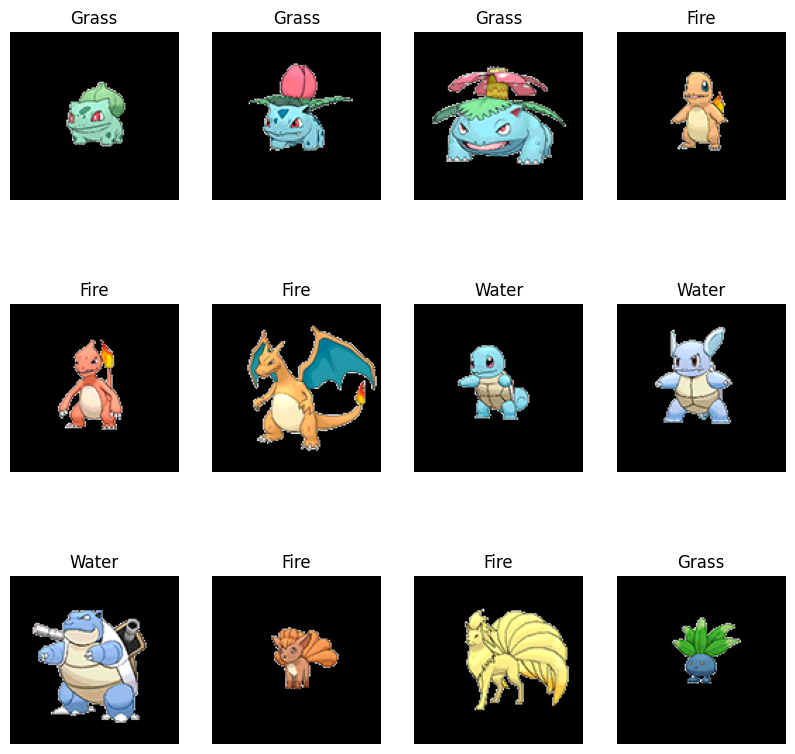

In [ ]:
#이미지 출력
plt.figure(figsize = (10, 10))

for i in range(12):
    plt.subplot(3, 4, i + 1)   #subplot 활용
    plt.axis(False)
    plt.imshow(images[i].reshape(120, 120, 3))
    plt.title(pokemons["Type1"].values[i])

In [ ]:
#train, test 분할
le = LabelEncoder()

X = pd.DataFrame(np.vstack(pokemons['Image'].values / 255))  #이미지 할당
y = le.fit_transform(pokemons["Type1"])  #타입

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

nb_classes = len(le.classes_)

In [ ]:
# 모델생성
model = Sequential()

model.add(Dense(nb_classes * 16, activation = "relu"))
model.add(Dropout(0.4))

model.add(Dense(nb_classes * 8, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(nb_classes * 4, activation = "relu"))
model.add(Dropout(0.1))

model.add(Dense(nb_classes, activation = "softmax"))

In [ ]:
#모델 학습
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
#모델 훈련
histo = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, verbose = 1)

Epoch 1/50
7/7 [==============================] - 2s 56ms/step - loss: 0.9732 - accuracy: 0.5102 - val_loss: 0.8564 - val_accuracy: 0.4898
Epoch 2/50
7/7 [==============================] - 0s 26ms/step - loss: 0.9036 - accuracy: 0.5357 - val_loss: 0.6587 - val_accuracy: 0.6122
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 0.7879 - accuracy: 0.5663 - val_loss: 0.6547 - val_accuracy: 0.6122
Epoch 4/50
7/7 [==============================] - 0s 18ms/step - loss: 0.7800 - accuracy: 0.5714 - val_loss: 0.6744 - val_accuracy: 0.6122
Epoch 5/50
7/7 [==============================] - 0s 18ms/step - loss: 0.8169 - accuracy: 0.5663 - val_loss: 0.6718 - val_accuracy: 0.6122
Epoch 6/50
7/7 [==============================] - 0s 16ms/step - loss: 0.8097 - accuracy: 0.5714 - val_loss: 0.6122 - val_accuracy: 0.5918
Epoch 7/50
7/7 [==============================] - 0s 17ms/step - loss: 0.8083 - accuracy: 0.5714 - val_loss: 0.6543 - val_accuracy: 0.6122
Epoch 8/50
7/7 [===========

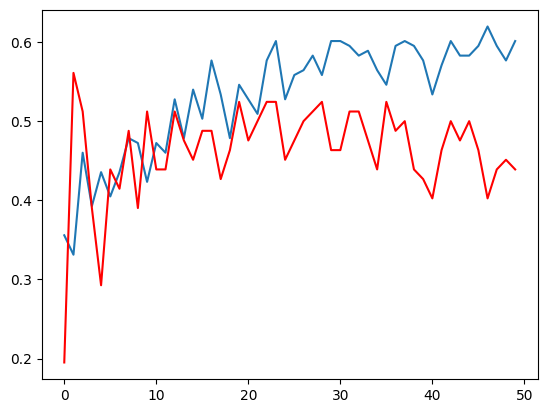

In [ ]:
accuracies = histo.history["accuracy"]
plt.plot(range(len(accuracies)), accuracies)

val_accuracies = histo.history["val_accuracy"]
plt.plot(range(len(val_accuracies)), val_accuracies, "r")